# Research question 1

- Embed each user story in user story dataset(persist in a datastore to avoid recomputation to avoid cost for commercial llm embedders)
- Cluster to get optimal k

__Questions I am wrestling with__
- How to get optimal cluster size k for each `user stories dataset`.
- How to embed the user stories with several embedding models.

__Methodology__
1. Dataset to be used is `data/g12-camperplus.txt`(__55 user stories__).
2. Preprocess by doing tokenization, lemmatization and removing stop words
3. Embed using any LLM embedding and TFIDF store in a vector database
4. Use K-means algorithm(by varying cluster between 2 and square root of n)
5. Evaluate using SC an CH index

#### Check number of user stories

In [13]:
SUPABASE_PROJECT_NAME = "g12-camperplus"

In [14]:
FILE_PATH = f"data/{SUPABASE_PROJECT_NAME}.txt"

In [15]:
number_of_user_stories = 0
with open(FILE_PATH) as file:
    for line in file:
        number_of_user_stories += 1

print(f"There are {number_of_user_stories} stories in a {FILE_PATH}")

There are 55 stories in a data/g12-camperplus.txt


#### Install packages needed for embedding user stories

In [16]:
#!pip install ollama langchain langchain_community

In [17]:
# !ollama pull llama3
# !ollama pull phi3
# !ollama pull mistral

Llama3, Phi-3 and Mistral take 20.25s, 9s, 12s for embedding a single query respectively. This means the higher the size of the model, the slower the embedding process

__Install packages for performing data preprocessing and storing embeddings__|

In [18]:
#!pip install nltk supabase

In [19]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import supabase 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from langchain_community.embeddings import OllamaEmbeddings

# Load stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load LLM models
llama_model = OllamaEmbeddings(model="llama3")
mistral_model = OllamaEmbeddings(model="mistral")
phi3_model = OllamaEmbeddings(model="phi3")

In [26]:
# Load user story data
# Connect to supabase vector store
# Proprocess each user story, embed and store in the database

### Load user story data

In [27]:
with open(FILE_PATH, 'r') as file:
    user_stories = file.readlines()

### Connect to supabase

In [11]:
#!pip install python-dotenv

In [28]:
from dotenv import dotenv_values
# Load environment variables from .env file
env_variables = dotenv_values(".env")

In [29]:
import os
from supabase import create_client, Client

url: str = env_variables.get("SUPABASE_URL")
key: str = env_variables.get("SUPABASE_KEY")
supabase_client: Client = create_client(url, key)

### Creating necessary functions for embedding user stories and storing them in supabase vector store

In [21]:
def preprocess_story(story):
    
    """
    Preprocesses a user story by tokenizing, lemmatizing, and removing stop words.
    """
    tokens = word_tokenize(story.lower().strip())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(filtered_tokens)

def get_embeddings(story):
    """
    Generates embeddings for a user story using LLAMA, Mistral, and Phi-3 models.
    """
    preprocessed_story = preprocess_story(story)
    llama_embedding = llama_model.embed_query(preprocessed_story)
    mistral_embedding = mistral_model.embed_query(preprocessed_story)
    phi3_embedding = phi3_model.embed_query(preprocessed_story)
    return {
        "llama_embedding": llama_embedding,
        "mistral_embedding": mistral_embedding,
        "phi3_embedding": phi3_embedding
    }

def store_data(index, story, embeddings):
    """
    Stores the preprocessed user story and embeddings in a Supabase vector database.
    """
    inserted_data = {
        "user_story_id": f"US-{index}",
        "story": story,
        "llama_embedding": embeddings["llama_embedding"],
        "mistral_embedding": embeddings["mistral_embedding"],
        "phi3_embedding": embeddings["phi3_embedding"]
    }
    
    # Try and rename the name of table below to the user stories
    supabase_client.table(SUPABASE_PROJECT_NAME).insert(inserted_data).execute()

### Preprocess, embed and store data and respective embeddings in supabase

In [15]:
import time

start_time = time.time()
for index, story in enumerate(user_stories):
    preprocessed_story = preprocess_story(story)
    print(f"Preprocessed story: {preprocessed_story} {index}")
    embeddings = get_embeddings(preprocessed_story)
    print(f"Done performing embedding {index}")
    store_data(index, preprocessed_story, embeddings)
    print(f"Done with US-{index}")
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Preprocessed story: ï » ¿as camp administrator want able add camper keep track individual camper 0
Done performing embedding 0
Done with US-0
Preprocessed story: camp administrator want able remove camper n't attend camp anymore keep record organized 1
Done performing embedding 1
Done with US-1
Preprocessed story: camp administrator want able keep camper record previous year amount work need lowered 2
Done performing embedding 2
Done with US-2
Preprocessed story: camp administrator want able upload consent form camper parent easily access form 3
Done performing embedding 3
Done with US-3
Preprocessed story: camp administrator want able keep track camper submitted form legal issue avoided 4
Done performing embedding 4
Done with US-4
Preprocessed story: camp administrator want able schedule activity camper camp worker easily keep track time 5
Done performing embedding 5
Done with US-5
Preprocessed story: camp administrator want able suspend camper behavioral problem 6
Done performing emb

__The embedding of the 55 user stories and storing in a database took about 39mins__

### Preprocess, embed with TFIDF and store in supabase

Since, schema has already been created, we do the following:
1. Add column `tfidf` to the schema 
2. preprocess user story
3. embed using tfidf
4. store tfidf vector in a database

In [22]:
SUPABASE_PROJECT_NAME = "g12-camperplus"

In [23]:
FILE_PATH = f"data/{SUPABASE_PROJECT_NAME}.txt"

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

def embed_with_tfidf(stories):
    """
    Generate embeddings/vector using TF-IDF
    """
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_embeddings = tfidf_vectorizer.fit_transform(stories)
    dense_embeddings = tfidf_embeddings.toarray()
    return dense_embeddings

In [45]:
with open(FILE_PATH, 'r') as file:
    user_stories = file.readlines()

In [46]:
import time

preprocessed_stories = []
for story in user_stories:
    preprocessed_stories.append(preprocess_story(story))

In [47]:
embeddings = embed_with_tfidf(preprocessed_stories)

In [49]:
import time

start_time = time.time()
for index, embedding in enumerate(embeddings):
    # Update tfidf column in "g12-camperplus" table in supabase
    supabase_client.table(SUPABASE_PROJECT_NAME).update({"tfidf": embedding.tolist()}).eq("user_story_id", f"US-{index}").execute()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for inserting/updating TFIDF embeddings for the user stories: {elapsed_time}")

Elapsed time for inserting/updating TFIDF embeddings for the user stories: 10.724145412445068


## NEXT STEPS AFTER EMBEDDING

1. Perform Kmeans on cluster size k ranging from 1 to ceiling(sqrt(55))
2. Get SC and CH index for each k
3. Plot k vs (SC and CH) for each embedding method

In [94]:
import supabase
import os
import pandas as pd
from supabase import create_client, Client
from dotenv import dotenv_values
# Load environment variables from .env file
env_variables = dotenv_values(".env")

# Connect to supbase client
url: str = env_variables.get("SUPABASE_URL")
key: str = env_variables.get("SUPABASE_KEY")
supabase_client = create_client(url, key)

FIELDS_TO_SELECT = ["user_story_id", "llama_embedding", "phi3_embedding", "mistral_embedding", "tfidf"]
response = supabase_client.table(SUPABASE_PROJECT_NAME).select(", ".join(FIELDS_TO_SELECT)).execute()
embeddings_data = response.data

In [95]:
embeddings_df = pd.DataFrame(embeddings_data)

In [96]:
llama_embeddings = embeddings_df["llama_embedding"]
num_rows = len(llama_embeddings)
print(f"Num of rows: {num_rows}")

Num of rows: 55


In [97]:
import ast
import numpy as np

# Convert embeddings data to numpy arrays
llama_embeddings = [np.array(ast.literal_eval(emb)) for emb in embeddings_df["llama_embedding"]]
phi3_embeddings = [np.array(ast.literal_eval(emb)) for emb in embeddings_df["phi3_embedding"]]
mistral_embeddings = [np.array(ast.literal_eval(emb)) for emb in embeddings_df["mistral_embedding"]]
tfidf_embeddings = [np.array(ast.literal_eval(emb)) for emb in embeddings_df["tfidf"]]

In [98]:
print(len(llama_embeddings[0]), len(llama_embeddings[5]))
print(len(phi3_embeddings[0]), len(phi3_embeddings[5]))
print(len(mistral_embeddings[0]), len(mistral_embeddings[5]))
print(len(tfidf_embeddings[0]), len(tfidf_embeddings[5]))

4096 4096
3072 3072
4096 4096
192 192


#### Experimenting with time for getting SC and CH scores per embeddings method

In [61]:
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

kmeans = KMeans(n_clusters=5, random_state=42, n_init=2000)

start_time = time.time()

llama_silhouette_scores, llama_calinski_harabasz_scores = [], []
clusters_llama = kmeans.fit_predict(llama_embeddings)
llama_silhouette_scores.append(silhouette_score(llama_embeddings, clusters_llama))
llama_calinski_harabasz_scores.append(calinski_harabasz_score(llama_embeddings, clusters_llama))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for computing SC and CH index on llama embeddings for a given cluster: {elapsed_time}")
print(llama_silhouette_scores, llama_calinski_harabasz_scores)

start_time = time.time()

phi3_silhouette_scores, phi3_calinski_harabasz_scores = [], []
clusters_phi3 = kmeans.fit_predict(phi3_embeddings)
phi3_silhouette_scores.append(silhouette_score(phi3_embeddings, clusters_phi3))
phi3_calinski_harabasz_scores.append(calinski_harabasz_score(phi3_embeddings, clusters_phi3))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for computing SC and CH on phi3 embeddings index for a given cluster: {elapsed_time}")
print(phi3_silhouette_scores, phi3_calinski_harabasz_scores )

start_time = time.time()

mistral_silhouette_scores, mistral_calinski_harabasz_scores = [], []
clusters_mistral = kmeans.fit_predict(mistral_embeddings)
mistral_silhouette_scores.append(silhouette_score(mistral_embeddings, clusters_mistral))
mistral_calinski_harabasz_scores.append(calinski_harabasz_score(mistral_embeddings, clusters_mistral))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for computing SC and CH index on phi3 embeddings for a given cluster: {elapsed_time}")
print(mistral_silhouette_scores, mistral_calinski_harabasz_scores)

start_time = time.time()

tfidf_silhouette_scores, tfidf_calinski_harabasz_scores = [], []
clusters_tfidf = kmeans.fit_predict(tfidf_embeddings)
tfidf_silhouette_scores.append(silhouette_score(tfidf_embeddings, clusters_tfidf))
tfidf_calinski_harabasz_scores.append(calinski_harabasz_score(tfidf_embeddings, clusters_tfidf))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for computing SC and CH index on tfidf embeddings for a given cluster: {elapsed_time}")
print(tfidf_silhouette_scores, tfidf_calinski_harabasz_scores)

Elapsed time for computing SC and CH index on llama embeddings for a given cluster: 133.75465512275696
[0.08167364543815751] [4.261947653247437]
Elapsed time for computing SC and CH on phi3 embeddings index for a given cluster: 133.99292063713074
[0.0669654556934339] [2.9081653304241217]
Elapsed time for computing SC and CH index on phi3 embeddings for a given cluster: 136.2045865058899
[0.09293736374672372] [3.691980933687187]
Elapsed time for computing SC and CH index on tfidf embeddings for a given cluster: 144.5954737663269
[0.04124163891468744] [2.218695941404983]


#### Generate SC and CH index for all k-values

In [99]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import math

# Define range of k values (2 to ceiling of half of the num of rows)
k_values = range(2, (num_rows // 2) + 1)

# Initialize lists to store evaluation metrics for each embedding
llama_silhouette_scores = []
llama_calinski_harabasz_scores = []
phi3_silhouette_scores = []
phi3_calinski_harabasz_scores = []
mistral_silhouette_scores = []
mistral_calinski_harabasz_scores = []
tfidf_silhouette_scores = []
tfidf_calinski_harabasz_scores = []

# Perform K-means clustering for each embedding and compute evaluation metrics
import time

start_time = time.time()
for k in k_values:
    # K-means clustering for llama embeddings
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=2000)
    clusters_llama = kmeans.fit_predict(llama_embeddings)
    llama_silhouette_scores.append(silhouette_score(llama_embeddings, clusters_llama))
    llama_calinski_harabasz_scores.append(calinski_harabasz_score(llama_embeddings, clusters_llama))

    # K-means clustering for phi3 embeddings
    clusters_phi3 = kmeans.fit_predict(phi3_embeddings)
    phi3_silhouette_scores.append(silhouette_score(phi3_embeddings, clusters_phi3))
    phi3_calinski_harabasz_scores.append(calinski_harabasz_score(phi3_embeddings, clusters_phi3))

    # K-means clustering for mistral embeddings
    clusters_mistral = kmeans.fit_predict(mistral_embeddings)
    mistral_silhouette_scores.append(silhouette_score(mistral_embeddings, clusters_mistral))
    mistral_calinski_harabasz_scores.append(calinski_harabasz_score(mistral_embeddings, clusters_mistral))

    # K-means clustering for tfidf embeddings
    clusters_tfidf = kmeans.fit_predict(tfidf_embeddings)
    tfidf_silhouette_scores.append(silhouette_score(tfidf_embeddings, clusters_tfidf))
    tfidf_calinski_harabasz_scores.append(calinski_harabasz_score(tfidf_embeddings, clusters_tfidf))

    print(f"Done with generating SC and CH index for cluster {k}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Done with generating SC and CH index for cluster 2
Done with generating SC and CH index for cluster 3
Done with generating SC and CH index for cluster 4
Done with generating SC and CH index for cluster 5
Done with generating SC and CH index for cluster 6
Done with generating SC and CH index for cluster 7
Done with generating SC and CH index for cluster 8
Done with generating SC and CH index for cluster 9
Done with generating SC and CH index for cluster 10
Done with generating SC and CH index for cluster 11
Done with generating SC and CH index for cluster 12
Done with generating SC and CH index for cluster 13
Done with generating SC and CH index for cluster 14
Done with generating SC and CH index for cluster 15
Done with generating SC and CH index for cluster 16
Done with generating SC and CH index for cluster 17
Done with generating SC and CH index for cluster 18
Done with generating SC and CH index for cluster 19
Done with generating SC and CH index for cluster 20
Done with generating

#### Save SC and CH scores into file

In [103]:
SCORE_FILE = "sc_ch_scores_1.txt"
SCORE_PAIR = {
    "llama": [llama_silhouette_scores, llama_calinski_harabasz_scores],
    "phi3": [phi3_silhouette_scores, phi3_calinski_harabasz_scores],
    "mistral": [mistral_silhouette_scores, mistral_calinski_harabasz_scores],
    "tfidf": [tfidf_silhouette_scores, tfidf_calinski_harabasz_scores]
}

In [104]:
with open(SCORE_FILE, "a") as file:
    file.write(f"METRICS SCORE FOR CLUSTERS: {', '.join(map(str, list(k_values)))}\n")
    file.write("====================================================================================\n")

for key, value in SCORE_PAIR.items():

    with open(SCORE_FILE, "a") as file:
        file.write(f"{key}_silhouette_score: {', '.join(map(str, value[0]))}\n")
        file.write(f"{key}_calinski_harabasz_score: {', '.join(map(str, value[1]))}\n")
        
with open(SCORE_FILE, "a") as file:
    file.write("====================================================================================\n\n")

### Plotting SC and CH scores vs cluster size

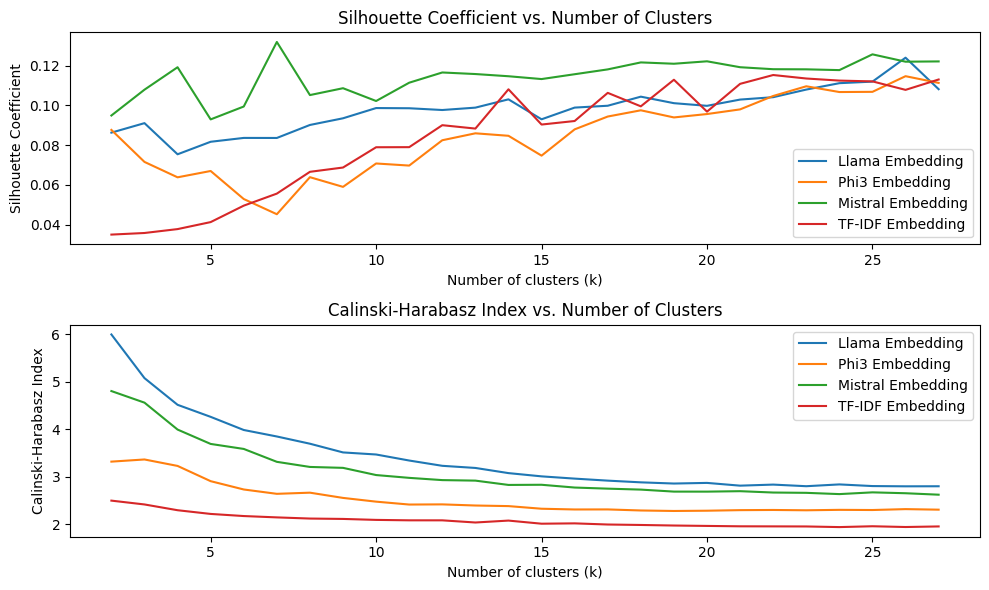

In [105]:
import matplotlib.pyplot as plt

# Plot k versus the evaluation metrics for each embedding
plt.figure(figsize=(10, 6))

# Plot Silhouette Coefficient
plt.subplot(2, 1, 1)
plt.plot(k_values, llama_silhouette_scores, label='Llama Embedding')
plt.plot(k_values, phi3_silhouette_scores, label='Phi3 Embedding')
plt.plot(k_values, mistral_silhouette_scores, label='Mistral Embedding')
plt.plot(k_values, tfidf_silhouette_scores, label='TF-IDF Embedding')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. Number of Clusters')
plt.legend()

# Plot Calinski-Harabasz Index
plt.subplot(2, 1, 2)
plt.plot(k_values, llama_calinski_harabasz_scores, label='Llama Embedding')
plt.plot(k_values, phi3_calinski_harabasz_scores, label='Phi3 Embedding')
plt.plot(k_values, mistral_calinski_harabasz_scores, label='Mistral Embedding')
plt.plot(k_values, tfidf_calinski_harabasz_scores, label='TF-IDF Embedding')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs. Number of Clusters')
plt.legend()

plt.tight_layout()
plt.show()


#### Investigating the clusters

In [106]:
max_silhouette_score = max(mistral_silhouette_scores)
index_of_the_cluster = mistral_silhouette_scores.index(max_silhouette_score)
cluster_size_with_max_silhooette_score = list(k_values)[index_of_the_cluster]
print(f"Cluster size with max silhouette score for mistral embeddings: {cluster_size_with_max_silhooette_score}")

Cluster size with max silhouette score for mistral embeddings: 7


#### Investigate user stories in each cluster for k = 7 using mistral embeddings

In [108]:
user_story_ids = embeddings_df["user_story_id"]

In [110]:
user_id = "US-6"
num = int(user_id.split("-")[1])
num

6

In [112]:
from sklearn.cluster import KMeans

mistral_embeddings = [np.array(ast.literal_eval(emb)) for emb in embeddings_df["mistral_embedding"]]
user_story_ids = embeddings_df["user_story_id"]

with open(FILE_PATH, 'r') as file:
    user_stories = file.readlines()

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=7, random_state=42, n_init=2000)
kmeans.fit(mistral_embeddings)

# Get cluster assignments for each user story
user_story_clusters = kmeans.labels_

# Create a dictionary to store user stories for each cluster
clusters = {i: [] for i in range(7)}

# Group user stories by their cluster assignments
for user_story_id, cluster in zip(user_story_ids, user_story_clusters):
    num = int(user_story_id.split("-")[1])
    # num represents the index of story in the file(This is done in order to account for unordering of user_story_id in database)
    clusters[cluster].append(num)

# Print user stories in each cluster
for cluster, user_story_ids in clusters.items():
    print(f"Cluster {cluster}:")
    for user_story_id in user_story_ids:
        print(user_stories[user_story_id])
    print()

Cluster 0:
As a camp administrator I want to be able to suspend a camper who had behavioral problems 

As a camp administrator I want to store campers' emergency information in a database  so that I can easily notify the necessary parties in case of an emergency 

As a camp administrator I want to be able to create a registration form for both staff and kids  so that I can keep organized 

As a camp administrator I want to be able to see only events for a specific group groups on the event calendar  so that I can easily read the data on the calendar without too much clutter 

As a camp administrator I want to be able to see medical forms  so that we can be prepared for an allergy attack

As a camp worker I would be able to submit a completion report for the tasks which was assigned to me 

As a camp counselor I want to be able to take attendance of my assigned kids  so that I can make ensure everybody is accounted for 

As a camp administrator I want to be able to remove campers if the

In [113]:
user_story_clusters

array([0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 4, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 3, 0, 4, 0, 2, 1, 0, 0,
       0, 5, 0, 0, 5, 3, 0, 3, 4, 0, 1])